In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from skimage.segmentation import mark_boundaries
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, structure_tensor_eigenvalues, hessian_matrix_eigvals
from skimage.color import rgb2gray
from skimage.filters import gabor, median, gaussian, frangi
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.transform import resize
from skimage.util import img_as_ubyte
from scipy.ndimage import generic_filter
import joblib
import pywt
import time
import json
import glob
import random
from collections import Counter
from sklearn.utils import resample

In [2]:
class SemiSupervisedSegmentation:
    def __init__(self):
        """
        Initialize the semi-supervised segmentation model
        
        Args:
            n_clusters: Number of clusters for unsupervised areas
            n_estimators: Number of estimators for RandomForest
            feature_importance_threshold: Threshold for selecting important features
            pca_components: Number of PCA components (None = no PCA)
            save_dir: Directory to save model outputs
        """

        # Store feature names
        self.feature_names = []
        
        # Store class mappings
        self.class_mapping = {}
        self.reverse_class_mapping = {}
        
        # Store selected feature indices
        self.selected_features = None
    def extract_features(self, img):
            """
            Extract various image features
            
            Args:
                img: Input image (RGB)
                
            Returns:
                features: Array of features for each pixel
            """
            # Get image dimensions
            height, width = img.shape[:2]
            
            # Convert to grayscale for some features
            if len(img.shape) > 2:
                gray = rgb2gray(img)
            else:
                gray = img.copy()
            
            # Initialize feature list
            features = []
            self.feature_names = []
            pca_feature_names = []
            
            # 1. Color features (RGB)
            rgb_features = []
            if len(img.shape) > 2:
                for i, channel_name in enumerate(['R', 'G', 'B']):
                    rgb_features.append(img[:,:,i].reshape(-1, 1))
                    #self.feature_names.append(f'color_{channel_name}')
            pca_feature_names.append('rgb_features')

            # 2. Color features (HSV)
            hsv_features = []
            if len(img.shape) > 2:
                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # or cv2.COLOR_BGR2HSV if your image is in BGR
                for i, channel_name in enumerate(['H', 'S', 'V']):
                    hsv_features.append(hsv[:, :, i].reshape(-1, 1))
                    #self.feature_names.append(f'color_{channel_name}')
            pca_feature_names.append('hsv_features')
            
            # 3. Median Filter
            median_img = median(gray, footprint=disk(5))
            features.append(median_img.reshape(-1, 1))
            self.feature_names.append('median')
            
            # 4. Gaussian Blur at multiple scales
            gaussian_features = []
            for sigma in [1, 3, 5]:
                gaussian_img = gaussian(gray, sigma=sigma)
                gaussian_features.append(gaussian_img.reshape(-1, 1))
                #self.feature_names.append(f'gaussian_sigma{sigma}')
            pca_feature_names.append('gaussian_features')
            
            # 5. GLCM features
            glcm_features = []
            glcm_props = ['contrast', 'correlation', 'energy', 'homogeneity']
            distances = [1, 3]
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            
            # Convert to uint8 for GLCM
            gray_uint8 = img_as_ubyte(gray)
            
            for prop in glcm_props:
                for distance in distances:
                    # Calculate GLCM for all angles at once
                    glcm = graycomatrix(gray_uint8, 
                                        distances=[distance], 
                                        angles=angles, 
                                        symmetric=True, 
                                        normed=True)
                    
                    # Get property for each angle
                    for i, angle in enumerate(angles):
                        prop_val = graycoprops(glcm, prop)[0, i]
                        # Create an image with the same value for all pixels
                        prop_img = np.full(gray.shape, prop_val, dtype=np.float64)
                        glcm_features.append(prop_img.reshape(-1, 1))

                        #self.feature_names.append(f'glcm_{prop}_d{distance}_a{i}')
            pca_feature_names.append('glcm_features')
            
            # 6. Canny Edge Detector
            canny_features = []
            # Convert to uint8 for Canny
            gray_uint8 = img_as_ubyte(gray)
            for threshold in [(50, 150), (100, 200)]:
                canny_edges = cv2.Canny(gray_uint8, threshold[0], threshold[1])
                canny_features.append(canny_edges.reshape(-1, 1) / 255.0)  # Normalize to [0,1]
                #self.feature_names.append(f'canny_{threshold[0]}_{threshold[1]}')
            pca_feature_names.append('canny_features')

            
            # 7-8. Fourier Transform Bandpower
            f_transform = np.fft.fft2(gray)
            f_transform_shifted = np.fft.fftshift(f_transform)
            magnitude_spectrum = np.log1p(np.abs(f_transform_shifted))
            
            # Create a mask for low frequencies
            rows, cols = gray.shape
            crow, ccol = rows // 2, cols // 2
            mask_low = np.zeros((rows, cols), dtype=np.float64)
            mask_high = np.ones((rows, cols), dtype=np.float64)
            
            # Low frequency mask - center circle
            r_low = min(rows, cols) // 4
            y, x = np.ogrid[:rows, :cols]
            mask_low_area = (y - crow) ** 2 + (x - ccol) ** 2 <= r_low ** 2
            mask_low[mask_low_area] = 1
            
            # High frequency mask - inverse of low frequency
            mask_high = 1 - mask_low
            
            # Apply masks and compute power
            low_freq_power = np.sum(magnitude_spectrum * mask_low) / np.sum(mask_low)
            high_freq_power = np.sum(magnitude_spectrum * mask_high) / np.sum(mask_high)
            
            # Create feature maps
            low_freq_map = np.full_like(gray, low_freq_power)
            high_freq_map = np.full_like(gray, high_freq_power)
            
            features.append(low_freq_map.reshape(-1, 1))
            features.append(high_freq_map.reshape(-1, 1))
            self.feature_names.extend(['fourier_low_freq', 'fourier_high_freq'])

            # 9. Frangi Vesselness Filter
            frangi_features = []
            for sigma in [1, 2, 3]:
                frangi_img = frangi(gray, sigmas=range(1, sigma+1))
                frangi_features.append(frangi_img.reshape(-1, 1))
                #self.feature_names.append(f'frangi_sigma{sigma}')
            pca_feature_names.append('frangi_features')


            expected_shape = (height * width, 1)
            print(expected_shape)
            # Final feature matrix
            final_pca_set = []
            final_pca_names = []
            pca_feature_list = [rgb_features,hsv_features,gaussian_features,glcm_features,canny_features,frangi_features]

            def scale_and_pca(features):
                X = np.hstack(features)
                pca_scaler = StandardScaler()
                X_scaled = pca_scaler.fit_transform(X)
                X_pca = PCA(n_components=1).fit_transform(X_scaled)
                return X_pca

            # Loop through feature group names
            for feature_group, name in zip(pca_feature_list,pca_feature_names):  # Or pass in a `locals()` dict if inside a function
                stacked = np.hstack(feature_group)
                if stacked.shape[0] == expected_shape[0]:
                    X_pca = scale_and_pca(feature_group)
                        # Add each PCA column individually
                    for i in range(X_pca.shape[1]):
                        print(f"Adding feature '{name}' with shape {stacked.shape}")
                        final_pca_set.append(X_pca[:, i].reshape(-1, 1))
                        final_pca_names.append(name)
                else:
                    print(f"Skipping feature '{name}' with shape {stacked.shape}")
            # Concatenate all features
            cleaned_features = []
            cleaned_names = []

            for feat, name in zip(features, self.feature_names):
                if feat.shape == expected_shape:
                    cleaned_features.append(feat)
                    cleaned_names.append(name)
                else:
                    print(f"Skipping feature '{name}' with shape {feat.shape}")

            # Replace original lists with cleaned ones
            all_features = cleaned_features + final_pca_set
            print(f'Length of cleaned_features is {len(cleaned_features)}')
            print(f'Length of pca_features is {len(final_pca_set)}')
            print(f'Length of all_features is {len(all_features)}')
            self.features = np.hstack(all_features)
            self.feature_names = cleaned_names + final_pca_names
            print(f'Length of feature names is {len(self.feature_names)}')
            print(self.feature_names)
            return self.features

In [54]:
import numpy as np

def map_clusters_to_labels_by_purity(cluster_labels, annotation_mask, background_label=0):
    """
    Map each cluster to the annotation label with highest purity (most common),
    excluding background unless no other label is present.

    Returns:
        cluster_to_label: dict mapping cluster_id → label
        overall_purity: float (foreground-weighted purity across all clusters)
    """
    mapped_segmentation = np.full_like(cluster_labels, fill_value=-1)
    flat_clusters = cluster_labels.flatten()
    flat_annotations = annotation_mask.flatten()

    unique_clusters = np.unique(flat_clusters)
    cluster_to_label = {}

    total_purity_score = 0
    total_foreground_pixels = np.sum(flat_annotations != background_label)

    for cluster_id in unique_clusters:
        cluster_mask = flat_clusters == cluster_id
        labels_in_cluster = flat_annotations[cluster_mask]

        if labels_in_cluster.size == 0:
            cluster_to_label[cluster_id] = background_label
            continue

        # Ensure indexing includes background label at minimum
        label_counts = np.bincount(labels_in_cluster, minlength=np.max(flat_annotations) + 1)
        cluster_size = labels_in_cluster.size
        label_purities = label_counts / cluster_size

        # Avoid assigning background unless no better option
        if background_label < len(label_purities):
            label_purities[background_label] = 0

        best_label = np.argmax(label_purities)
        best_purity = label_purities[best_label]

        # Optional: Merge label 2 into label 0
        if best_label == 2:
            best_label = 0

        cluster_to_label[cluster_id] = best_label

        non_bg_mask = labels_in_cluster != background_label
        non_bg_count = np.sum(non_bg_mask)
        total_purity_score += best_purity * non_bg_count

    for cluster_id, label in cluster_to_label.items():
        mapped_segmentation[cluster_labels == cluster_id] = label

    overall_purity = total_purity_score / total_foreground_pixels if total_foreground_pixels > 0 else 0

    return cluster_to_label, overall_purity


In [4]:
# ======== FUNCTION 1: DISPLAY CLUSTER LEGEND ========
def show_cluster_legend(segmented_img, num_clusters, title, legend_title):
    """
    Displays a legend for the colormap used in the cluster segmentation.
    """
    cmap = plt.get_cmap("tab10", num_clusters)  # Use a discrete colormap
    plt.figure(figsize=(8, 8))
    plt.imshow(segmented_img, cmap=cmap)
    plt.axis("off")
    plt.title(title)

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) 
               for i in range(num_clusters)]
    labels = [f"Cluster {i}" for i in range(num_clusters)]
    plt.legend(handles, labels, loc="upper right", title=legend_title)
    
    plt.show()

In [5]:
# ======== FUNCTION 2: MERGE CLUSTER GROUPS ========
def merge_clusters(segmented_img, merge_dict):
    """
    Allows merging of cluster groups into new groups.
    """
    merged_img = np.copy(segmented_img)
    
    # Replace cluster labels based on merge_dict
    for old_label, new_label in merge_dict.items():
        merged_img[segmented_img == old_label] = new_label
    
    return merged_img

In [6]:
annotation_mask = np.load("C:/Users/des346/Desktop/Code Projects/Grape/Binary/4.npy")
annotation = annotation_mask.flatten()

In [7]:
import math
import itertools

In [8]:
orig = cv2.imread("C:/Users/des346/Desktop/Code Projects/Grape/Tiles/corrected images/4.jpg")
image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

annotation_mask = np.load("C:/Users/des346/Desktop/Code Projects/Grape/Binary/4.npy")
annotation = annotation_mask.flatten()

semi = SemiSupervisedSegmentation()
features = semi.extract_features(image)

(1638400, 1)
Adding feature 'rgb_features' with shape (1638400, 3)
Adding feature 'hsv_features' with shape (1638400, 3)
Adding feature 'gaussian_features' with shape (1638400, 3)


c:\Users\des346\AppData\Local\miniforge3\envs\leaf-hair\lib\site-packages\sklearn\preprocessing\_data.py:1037: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask
c:\Users\des346\AppData\Local\miniforge3\envs\leaf-hair\lib\site-packages\sklearn\decomposition\_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Adding feature 'glcm_features' with shape (1638400, 32)
Adding feature 'canny_features' with shape (1638400, 2)
Adding feature 'frangi_features' with shape (1638400, 3)
Length of cleaned_features is 3
Length of pca_features is 6
Length of all_features is 9
Length of feature names is 9
['median', 'fourier_low_freq', 'fourier_high_freq', 'rgb_features', 'hsv_features', 'gaussian_features', 'glcm_features', 'canny_features', 'frangi_features']


In [10]:
from hdbscan import HDBSCAN
import random

In [ ]:


n_total_features = features.shape[1]
feature_indices = list(range(n_total_features))
feature_names = ['median', 'fourier_low_freq', 'fourier_high_freq', 'rgb_features', 'hsv_features', 'gaussian_features', 'glcm_features', 'canny_features', 'frangi_features']
min_features = 5
max_features = 9
best_image = [0, # purity
            0, # num features
            [], # set of features
            0, # num clusters
            {}, # mapping
            ]
max_iterations = 10
iteration_count = 0
stop_flag = False
for i in range(min_features, max_features + 1):
    print(f"\n=== Trying all combinations with {i} features ===")
    
    combinations = itertools.combinations(feature_indices, i)
    
    for sampled_indices in combinations:
        sampled_indices = list(sampled_indices)  # Convert tuple to list
        features2 = features[:, sampled_indices]

        for k in range(6,15):
            iteration_count += 1
            if iteration_count > max_iterations:
                stop_flag = True
                break
            #kmeans = KMeans(n_clusters=k, random_state=42)
            #labels = kmeans.fit_predict(features2)
            clusterer = HDBSCAN(min_cluster_size=15)
            labels = clusterer.fit_predict(features2)
            mapping, purity = map_clusters_to_labels_by_purity(labels, annotation)
            if purity > best_image[0]:
                print(f'New Best Image: {purity} Purity score')
                print(f'Set of Features: {sampled_indices}')
                for i in range(k):
                    print(f'Number of clusters: {k}')
                print(f'Mapping: {mapping}')
                best_image[0] = purity
                best_image[1] = i
                best_image[2] = sampled_indices
                best_image[3] = k
                best_image[4] = mapping
        if stop_flag:
            break
    if stop_flag:
        break

In [58]:
n_total_features = features.shape[1]
feature_indices = list(range(n_total_features))
feature_names = ['median', 'fourier_low_freq', 'fourier_high_freq', 'rgb_features', 'hsv_features', 'gaussian_features', 'glcm_features', 'canny_features', 'frangi_features']
min_features = 5
max_features = 9
best_image = [0, # purity
            0, # num features
            [], # set of features
            0,
            {}, # mapping
            ]

stop_flag = False
for i in range(min_features, n_total_features + 1):
    print(f"\n=== Trying all combinations with {i} features ===")
    
    # All possible combinations of i features
    all_combos = list(itertools.combinations(feature_indices, i))
    #random.shuffle(all_combos)  # Shuffle the order
    #print(len(all_combos))
    #sampled_combos = random.sample(all_combos, min(len(all_combos), 400))
    #print(sampled_combos)
    
    for sampled_indices in all_combos:
        #print(sampled_indices)
        
        sampled_indices = list(sampled_indices)  # Convert tuple to list
        features2 = features[:, sampled_indices]
        #print(f"Testing features: {[feature_names[j] for j in sampled_indices]}")
        #print(f"Sampled {len(sampled_combos)} combinations from {len(all_combos)} total")

        #print(feature_names[:, sampled_indices])
        
        for k in range(15, 40):  # try different cluster counts
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(features2)
            mapping, purity = map_clusters_to_labels_by_purity(labels, annotation)
            #print(f'Tested combo {sampled_indices} with k={k} → Purity: {purity:.4f}')
            if purity > best_image[0]:
                print(f'New Best Image: {purity:.4f} Purity score')
                print(feature_names[:, sampled_indices])
                #print(f'Set of Features: {sampled_indices}')
                #print(f'Number of clusters: {k}')
                #print(f'Mapping: {mapping}')
                best_image[0] = purity
                best_image[1] = i
                best_image[2] = sampled_indices
                best_image[3] = k
                best_image[4] = mapping

    

New Best Image: 0.3009 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 15
New Best Image: 0.3011 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 16
New Best Image: 0.3013 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 17
New Best Image: 0.3021 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 18
New Best Image: 0.3041 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 21
New Best Image: 0.3042 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 24
New Best Image: 0.3044 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 25
New Best Image: 0.3055 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 26
New Best Image: 0.3057 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 28
New Best Image: 0.3060 Purity score
Set of Features: [0, 1, 2, 3, 4, 5, 6]
Number of clusters: 30
New Best Image: 0.30

In [59]:
gray = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
height, width = gray.shape
segmented_image = labels.reshape(height, width)

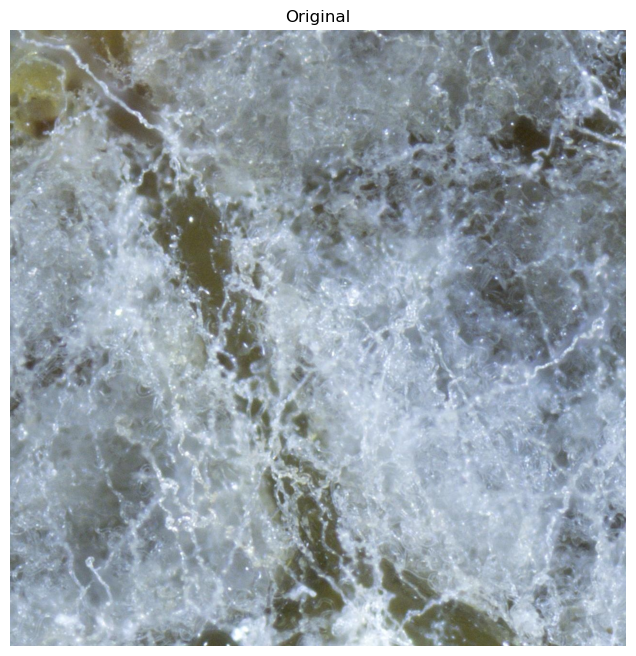

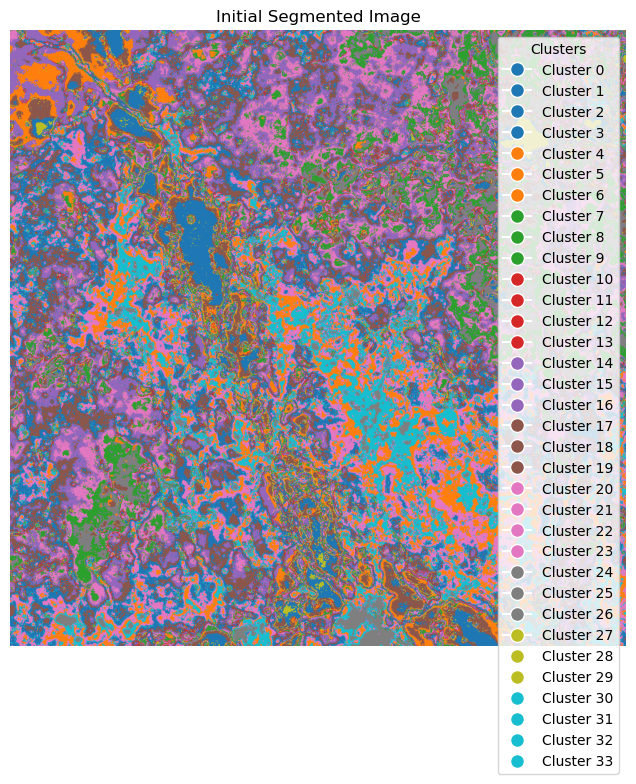

{0: 3, 1: 3, 2: 3, 3: 1, 4: 3, 5: 3, 6: 3, 7: 0, 8: 3, 9: 1, 10: 3, 11: 3, 12: 3, 13: 3, 14: 1, 15: 3, 16: 0, 17: 3, 18: 0, 19: 1, 20: 3, 21: 3, 22: 1, 23: 3, 24: 0, 25: 1, 26: 0, 27: 1, 28: 3, 29: 0, 30: 3, 31: 0, 32: 3, 33: 3}


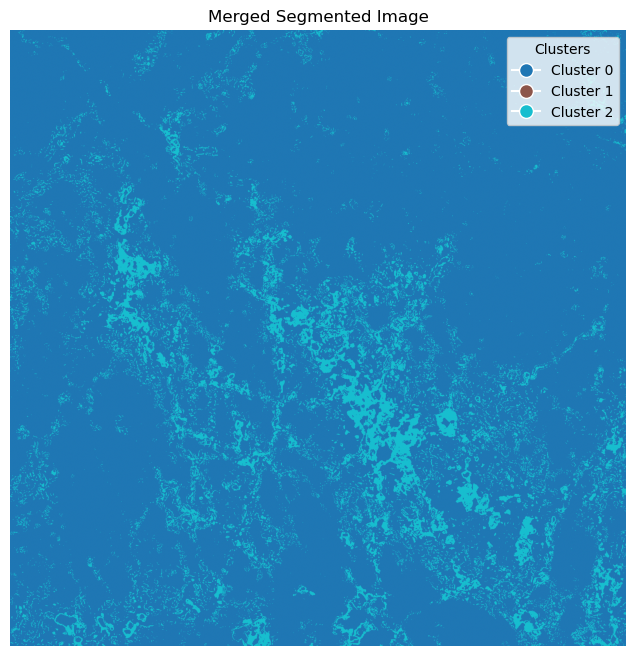

In [60]:
#cmap = plt.get_cmap("viridis", num_clusters)  # Use a discrete colormap
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.title("Original")

# Show original segmentation with legend
show_cluster_legend(segmented_image, best_image[3], "Initial Segmented Image", "Clusters")
print(best_image[4])
# Show new segmentation with legend
merged_image = merge_clusters(segmented_image, best_image[4])
show_cluster_legend(merged_image, 3, "Merged Segmented Image", "Clusters")